<a href="https://colab.research.google.com/github/Soukainnaaa/Soukainnaaa/blob/main/RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall --yes opencv-contrib-python opencv-python

Found existing installation: opencv-contrib-python 4.8.0.76
Uninstalling opencv-contrib-python-4.8.0.76:
  Successfully uninstalled opencv-contrib-python-4.8.0.76
Found existing installation: opencv-python 4.8.0.76
Uninstalling opencv-python-4.8.0.76:
  Successfully uninstalled opencv-python-4.8.0.76


In [2]:
!pip  install opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 8.6 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"soukii","key":"c6d4cc522a9dee526013948194d442a4"}'}

In [5]:
 ! mkdir ~/.kaggle

 ! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sshikamaru/car-object-detection

 79% 89.0M/112M [00:00<00:00, 167MB/s]
100% 112M/112M [00:00<00:00, 177MB/s] 


In [7]:
!unzip /content/car-object-detection.zip -d car-object-detection

Archive:  /content/car-object-detection.zip
  inflating: car-object-detection/data/sample_submission.csv  
  inflating: car-object-detection/data/testing_images/vid_5_25100.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25120.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25140.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25160.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25180.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25200.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25220.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25240.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_25260.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_26320.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_26400.jpg  
  inflating: car-object-detection/data/testing_images/vid_5_26420.jpg  
  inflating: car-object-detec

In [8]:
print('Image(Train):', len(os.listdir('/content/car-object-detection/data/training_images')))
print('Image(Test):', len(os.listdir('/content/car-object-detection/data/testing_images')))


Image(Train): 1001
Image(Test): 175


In [9]:
Data=pd.read_csv('/content/car-object-detection/data/train_solution_bounding_boxes (1).csv')

In [10]:
Data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [11]:
print('nombre de localisation dans Train data:', len(Data))


nombre de localisation dans Train data: 559


In [12]:
Data.values.shape

(559, 5)

Annotations (Check)

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


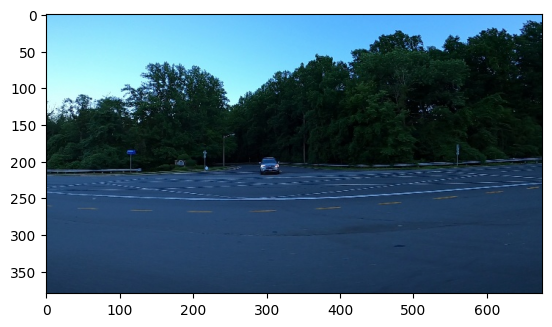

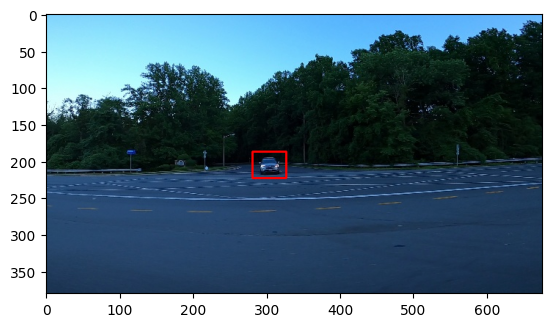

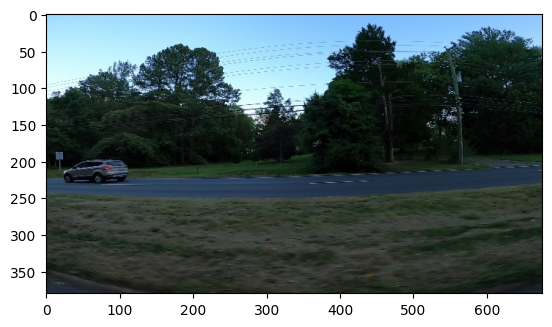

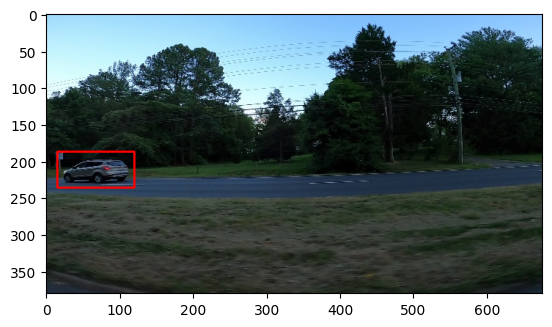

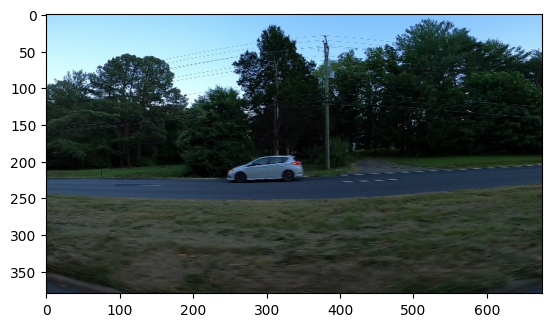

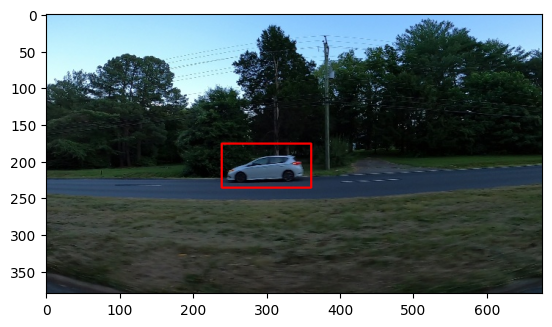

In [13]:
for a,i in enumerate(Data.values):
  img=plt.imread('/content/car-object-detection/data/training_images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),2)
  plt.figure()
  plt.imshow(img)
  if a ==2:
    break

Selective Search pour cherhcer ROIs

taille de l'image: (224, 224, 3)
nombre eventuel de boites englobantes: 213


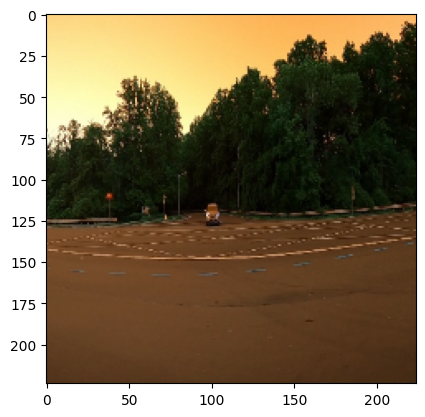

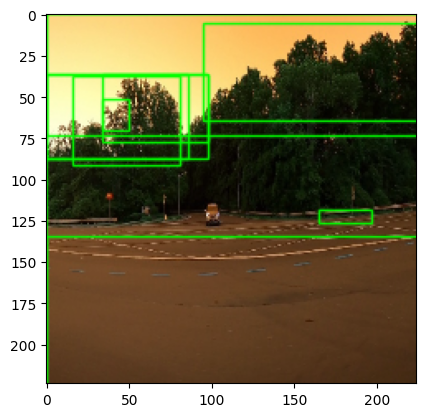

In [14]:
cv2.setUseOptimized(True) #Optimisation
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() #Creation

im = cv2.imread('/content/car-object-detection/data/training_images/vid_4_1000.jpg')
im=cv2.resize(im,(224,224))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im) #chargement de l'image
ss.switchToSelectiveSearchFast()# utilisation de la version fast de l'algo de la recherche selective
rects= ss.process()# recuperation des boites englobantes
print("taille de l'image:", im.shape)
print("nombre eventuel de boites englobantes:", len(rects))

for rect in rects[:10]:
  x,y,w,h = rect
  imOut=cv2.rectangle(im,(x,y), (x+w, y+h), (0,255,0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut)


In [15]:
print(rect)

[  0 135 224  89]


IOU algorithme

In [16]:
ss=cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
#def get_iou(bb1,bb2):
  #assert bb1['x1'] < bb1['x2']
  #assert bb1['y1'] < bb1['y2']

  #assert bb2['x1'] < bb2['x2']
  #assert bb2['y1'] < bb2['y2'];

  #x_left= max(bb1['x1'], bb2['x1'])
  #y_top= max(bb1['y1'], bb2['y1'])
  #x_right= min((bb1['x2'], bb2['x2']))
  #y_bottom= min((bb1['y2'], bb2['y2']))

  #if x_right < x_left or y_bottom < y_top:
    #return 0.0
  #intersection_area = (x_right -  x_left) * ( y_bottom - y_top)
  #bb1_area =(bb1['x2'] - bb1['x1'])* (bb1['y2']-bb1['y1'])
  #bb2_area =(bb2['x2'] - bb2['x1'])* (bb2['y2']-bb2['y1'])
  #iou= intersection_area / float(bb1_area  + bb1_area - intersection_area)
  #assert iou >= 0.0
  #assert iou <= 1.0
  #return iou

In [25]:
def get_iou(bb1,bb2):
  assert bb1['x1']< bb1['x2'] #bb1
  assert bb1['y1']< bb1['y2']

  assert bb2['x1']< bb2['x2'] #bb2
  assert bb2['y1']< bb2['y2']

  x_left =max(bb1['x1'],bb2['x1'])
  y_top =max(bb1['y1'],bb2['y1'])
  x_right= min(bb1['x2'],bb2['x2'])
  y_bottom= min(bb1['y2'],bb2['y2'])

  if x_right < x_left or y_bottom <y_top:
    return 0.0

  intersection_area=(x_right-x_left)*(y_bottom-y_top)
  bb1_area= (bb1['x2']-bb1['x1'])*(bb1['y2']-bb1['y1'])
  bb2_area=(bb2['x2']-bb2['x1'])*(bb2['y2']-bb2['y1'])
  iou = intersection_area/float(bb1_area+bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

Recuperation des ROIs à partir de chaque image de la BD

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


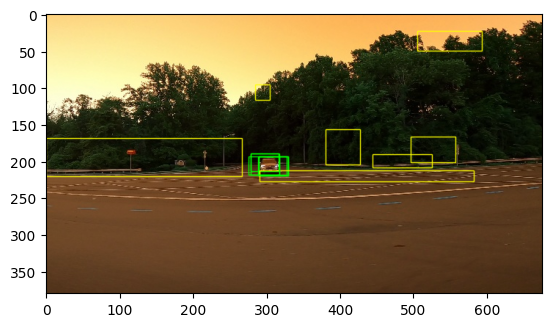

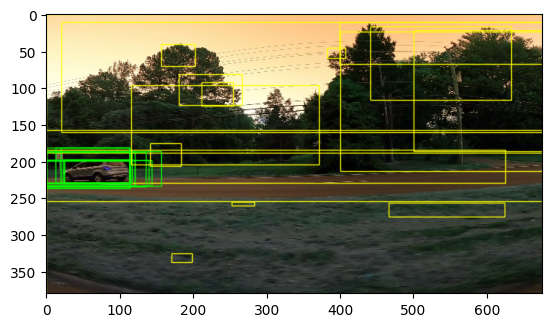

In [31]:
def getBDImage(image,ROI,bbreel):
  image_liste=[]
  labels=[]
  ious=[]
  rois=[]
  rois_reel=[]
  nb_no_cars=0
  nb_cars=0
  for rect in ROI:
    x, y, w, h = rect
    bbRoi={'x1':x,
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }

    imgExtraite=image[bbRoi['y1']:bbRoi['y2'],bbRoi['x1']:bbRoi['x2']] # Crop img
    img_reshape=cv2.resize(imgExtraite,(224,224))
    iou=get_iou(bbreel,bbRoi)

    #print(iou)
    if nb_cars<nb_no_cars:
      if iou>0.5:
              image_liste.append([img_reshape])
              labels.append(1)
              nb_cars=nb_cars+1
              ious.append(iou)
              rois.append(bbRoi)
              rois_reel.append(bbreel)

    else:
      ious.append(iou)
      image_liste.append([img_reshape])
      if iou>0.5:
        labels.append(1)
        nb_cars=nb_cars+1

        rois.append(bbRoi)
        rois_reel.append(bbreel)

      else:

       labels.append(0)
       nb_no_cars=nb_no_cars+1

       rois.append(bbRoi)
       rois_reel.append(bbRoi)

  return image_liste,labels,rois,rois_reel,ious



def visualisation(image,ROIs,bbreel):

  image_liste,labels,rois,iou,rois_reel=getBDImage(img,ROIs,bbreel)
  print(labels)

  for i in range(len(labels)):
    bb=rois[i]
    if(labels[i]==1):


      cv2.rectangle(image, (bb["x1"], bb["y1"]), (bb["x2"], bb["y2"]), (0, 255, 0), 1, cv2.LINE_AA)
    else:
      cv2.rectangle(image, (bb["x1"], bb["y1"]), (bb["x2"], bb["y2"]), (255, 255, 0), 1, cv2.LINE_AA)
  plt.figure()
  plt.imshow(image)
for i,a in enumerate(Data.values):
  Name,xmin,ymin,xmax,ymax=a
  bbreel={ #gerçek bounty boxxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  img=cv2.imread('/content/car-object-detection/data/training_images/'+Name)
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  ROIs = ss.process()

  #image_liste,labels,rois,iou=getBDImage(img,ROIs,bbreel)
  visualisation(img,ROIs,bbreel)
  if i==1:
    break

In [38]:
def getBDAllImage(Data):
  imagesROIs=[]
  labelsImages=[]
  CoordinatesRiOs=[]
  RiO_reel=[]
  for i,a in enumerate(Data.values):

    Name,xmin,ymin,xmax,ymax = a
    bbreel={
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
    img=cv2.imread('/content/car-object-detection/data/training_images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    ROIs = ss.process()

    print("image:",i, "nb RoIs:", len(ROIs))

    image_liste,labels,rois,rois_reel,iou=getBDImage(img,ROIs,bbreel)
    imagesROIs.extend(image_liste)
    labelsImages.extend(labels)
    CoordinatesRiOs.extend(rois_reel)
    if i==200:
      break
  #visualisation(img,ROIs,bbreel)
  return imagesROIs,labelsImages,RiO_reel,CoordinatesRiOs
imagesRoIs,labelsImages,RiO_reel,CoordinatesRiOs=getBDAllImage(Data)

image: 0 nb RoIs: 1101
image: 1 nb RoIs: 1456
image: 2 nb RoIs: 1403
image: 3 nb RoIs: 1489
image: 4 nb RoIs: 1315
image: 5 nb RoIs: 1537
image: 6 nb RoIs: 1430
image: 7 nb RoIs: 1544
image: 8 nb RoIs: 1117
image: 9 nb RoIs: 1146
image: 10 nb RoIs: 1663
image: 11 nb RoIs: 1815
image: 12 nb RoIs: 1725
image: 13 nb RoIs: 1251
image: 14 nb RoIs: 1894
image: 15 nb RoIs: 1676
image: 16 nb RoIs: 1754
image: 17 nb RoIs: 1553
image: 18 nb RoIs: 1779
image: 19 nb RoIs: 1863
image: 20 nb RoIs: 1846
image: 21 nb RoIs: 1884
image: 22 nb RoIs: 1929
image: 23 nb RoIs: 1925
image: 24 nb RoIs: 1880
image: 25 nb RoIs: 1801
image: 26 nb RoIs: 1824
image: 27 nb RoIs: 1857
image: 28 nb RoIs: 1947
image: 29 nb RoIs: 1932
image: 30 nb RoIs: 1970
image: 31 nb RoIs: 1901
image: 32 nb RoIs: 1979
image: 33 nb RoIs: 1971
image: 34 nb RoIs: 1879
image: 35 nb RoIs: 1870
image: 36 nb RoIs: 1821
image: 37 nb RoIs: 1632
image: 38 nb RoIs: 1632
image: 39 nb RoIs: 1682
image: 40 nb RoIs: 1682
image: 41 nb RoIs: 1682
im

In [41]:
imagesRoIs=np.array(imagesRoIs).reshape(-1,224,224,3)
labelsImages=np.array(labelsImages)
RiO_reel=np.array(RiO_reel)
CoordinatesRiOs=np.array(CoordinatesRiOs)
X=[]
for i in range(len(imagesRoIs)):
  X.append([imagesRoIs[i], labelsImages[i],CoordinatesRiOs[i]])


print("nombre d'image", len(imagesRoIs),"nombre de labels:",len(labelsImages))
print("taille des images", imagesRoIs.shape)
print("tailles des labels", labelsImages.shape)
print("taille des rois", RiO_reel.shape, CoordinatesRiOs.shape)
print(len(X))

print("nombre d'image qui ne contient aucune voiture", len(labelsImages[labelsImages==0]),"nombre d'image qui contient les voiture", len(labelsImages[labelsImages==1]))


nombre d'image 4381 nombre de labels: 4381
taille des images (4381, 224, 224, 3)
tailles des labels (4381,)
taille des rois (0,) (4381,)
4381
nombre d'image qui ne contient aucune voiture 2291 nombre d'image qui contient les voiture 2090


Class: 1
La taille de l'image: (224, 224, 3)


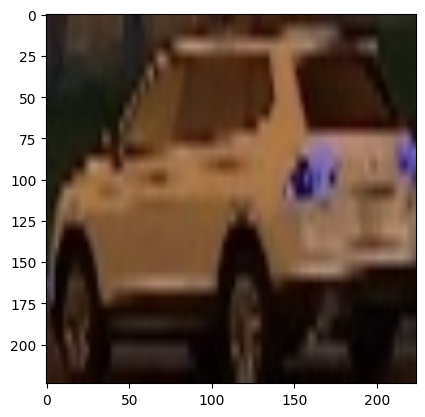

In [43]:
i=random.randint(1,len(labelsImages))
print('Class:',labelsImages[i])
print("La taille de l'image:",imagesRoIs[i].shape)
plt.imshow(imagesRoIs[i])
plt.show()

In [44]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train, y_val=train_test_split(X,labelsImages, test_size=0.33,random_state=42)

In [45]:
del X

In [47]:
(x_train[0][2])

{'x1': 0, 'y1': 191, 'x2': 88, 'y2': 229}

In [48]:
def getImagesAndROI(X_v):
  images=[]
  RoIsReel=[]
  RoIsSS=[]
  for i in range(len(X_v)):
    images.append(X_v[i][0])
    RoIsReel.append(X_v[i][1])
    RoIsSS.append(X_v[i][2])
  return np.array(images),np.array(RoIsReel),np.array(RoIsSS)


In [49]:
x_train_images,x_train_rois,x_train_roisSS= getImagesAndROI(x_train)
x_val_images,x_val_rois,x_val_roisSS=getImagesAndROI(x_val)

In [50]:
del x_train, x_val

In [51]:
x_train_images.shape

(2935, 224, 224, 3)

In [52]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(np.array(y_train),num_classes=2)
y_val= to_categorical(np.array(y_val),num_classes=2)

In [53]:
print("x_train shape",x_train_images.shape)
print("x_val shape",x_val_images.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

x_train shape (2935, 224, 224, 3)
x_val shape (1446, 224, 224, 3)
y_train shape (2935, 2)
y_val shape (1446, 2)
